# Import Modules

In [1]:
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics import F1Score
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters Config

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=45,
        input_size_left_context=64,
        input_size_oov_context=20,
        input_size_right_context=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        output_size=3611,
        shuffle=True,
        lr=0.001,
        batch_first=True,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=20,
        patience=20,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.input_size_left_context = input_size_left_context
        self.input_size_oov_context = input_size_oov_context
        self.input_size_right_context = input_size_right_context
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device
        
hyperparams = Hyperparams()

# Prepare Feature Dataset

In [3]:
def convert_doc_to_idxs(docs, dict_vocabs):
    doc_to_idx = []
    
    for doc in docs:
        doc_to_idx.append([dict_vocabs[token] for token in doc])
        
    return np.array(doc_to_idx)

# Left context
left_context = open(f"../../datasets/features/{hyperparams.context_size}_context/left_context_with_pad.pkl", "rb")
left_context = pickle.load(left_context)
left_context_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/token2idx_left_context.pkl", "rb")
left_context_to_idx = pickle.load(left_context_to_idx)
doc_left_context_to_idx = convert_doc_to_idxs(left_context, left_context_to_idx)

# OOV context
oov_context = open(f"../../datasets/features/{hyperparams.context_size}_context/oov_context_with_pad.pkl", "rb")
oov_context = pickle.load(oov_context)
oov_context_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/token2idx_oov_context.pkl", "rb")
oov_context_to_idx = pickle.load(oov_context_to_idx)
doc_oov_context_to_idx = convert_doc_to_idxs(oov_context, oov_context_to_idx)

# Right context
right_context = open(f"../../datasets/features/{hyperparams.context_size}_context/right_context_with_pad.pkl", "rb")
right_context = pickle.load(right_context)
right_context_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/token2idx_right_context.pkl", "rb")
right_context_to_idx = pickle.load(right_context_to_idx)
doc_right_context_to_idx = convert_doc_to_idxs(right_context, right_context_to_idx)

# Actual labels
labels_context = open(f"../../datasets/features/{hyperparams.context_size}_context/lables.pkl", "rb")
labels_context = pickle.load(labels_context)
labels_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/lable_vocabs.pkl", "rb")
labels_to_idx = pickle.load(labels_to_idx)
doc_labels_to_idx = convert_doc_to_idxs(labels_context, labels_to_idx).flatten()

print(f"Left context shape: {doc_left_context_to_idx.shape}")
print(f"OOV context shape: {doc_oov_context_to_idx.shape}")
print(f"Right context shape: {doc_right_context_to_idx.shape}")
print(f"Actual lable shape: {doc_labels_to_idx.shape}")

Left context shape: (16562, 45)
OOV context shape: (16562, 28)
Right context shape: (16562, 45)
Actual lable shape: (16562,)


In [4]:
# Convert to Tensor
left_contexts = torch.LongTensor(doc_left_context_to_idx)
oov_contexts = torch.LongTensor(doc_oov_context_to_idx)
right_contexts = torch.LongTensor(doc_right_context_to_idx)
actual_labels = torch.LongTensor(doc_labels_to_idx)
dataset = TensorDataset(left_contexts, oov_contexts, right_contexts, actual_labels)

# Char and Word Embedding

In [5]:
# Word Embedding
word_embeddings = Embedding.load("../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
word_embeddings.apply_expansion(DigitExpander)
word_embeddings.apply_expansion(CaseExpander)

left_vocabs = open(f"../../datasets/features/{hyperparams.context_size}_context/left_context_vocabs.pkl", "rb")
left_vocabs = pickle.load(left_vocabs)

right_vocabs = open(f"../../datasets/features/{hyperparams.context_size}_context/right_context_vocabs.pkl", "rb")
right_vocabs = pickle.load(right_vocabs)

left_word_embedding_dict = {left_context_to_idx[vocab] : word_embeddings[vocab] for vocab in left_vocabs}
right_word_embedding_dict = {right_context_to_idx[vocab] : word_embeddings[vocab] for vocab in right_vocabs}

# Char Embedding
char_embedding_dict = open("../../word_embeddings/chars_embedding/char_embeddings.pkl", "rb")
char_embedding_dict = pickle.load(char_embedding_dict)

# Context embedding
left_context_embedding = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(left_word_embedding_dict.values()))), padding_idx=left_vocabs.index("<PAD>"), freeze=True)
oov_context_embedding = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(char_embedding_dict.values()))), padding_idx=list(char_embedding_dict.keys()).index("PAD"), freeze=True)
right_context_embedding = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(right_word_embedding_dict.values()))), padding_idx=right_vocabs.index("<PAD>"), freeze=True)

# Dataloader

In [6]:
dataloader = DataLoader(dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

# Model

In [7]:
class Comick(nn.Module):
    def __init__(
        self,
        input_size_left_context=hyperparams.input_size_left_context,
        input_size_oov_context=hyperparams.input_size_oov_context,
        input_size_right_context=hyperparams.input_size_right_context,
        hidden_size=hyperparams.hidden_size,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(Comick, self).__init__()
        
        self.input_size_left_context = input_size_left_context
        self.input_size_oov_context = input_size_oov_context
        self.input_size_right_context = input_size_right_context
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        
        self.bilstm_left_context_feature = nn.LSTM(
            input_size = self.input_size_left_context,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.bilstm_oov_context_feature = nn.LSTM(
            input_size = self.input_size_oov_context,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.bilstm_right_context_feature = nn.LSTM(
            input_size = self.input_size_right_context,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.fc = nn.Sequential(
            nn.Linear(2 * self.hidden_size, 64),
            nn.Tanh()
        )
        
        self.oov_embedding = nn.Linear(in_features=3 * 64, out_features=64)
        
        self.embedding = np.empty((output_size, 64), dtype=np.float32)
        
        self.prob = nn.Sequential(
            nn.Linear(64, self.output_size),
            nn.LogSoftmax(dim=1)
        )
                
        if init_wb_with_kaiming_normal:
            self.init_wb()
            
    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))

    def forward(
        self,
        input_left_context,
        input_oov_context,
        input_right_context,
        idxs_target,
        hidden_left_context=None,
        hidden_oov_context=None,
        hidden_right_context=None,
    ):
        # BiLSTM left, oov, and right context
        output_left_context, (hidden_left_context, memory_left_context) = self.bilstm_left_context_feature(input_left_context, hidden_left_context)
        output_oov_context, (hidden_oov_context, memory_oov_context) = self.bilstm_oov_context_feature(input_oov_context, hidden_oov_context)
        output_right_context, (hidden_right_context, memory_right_context) = self.bilstm_right_context_feature(input_right_context, hidden_right_context)
                
        # Concate hidden (forward and backward hidden BiLSTM)
        hidden_left_bidirectional = torch.cat((hidden_left_context[0], hidden_left_context[-1]), dim=1)
        hidden_oov_bidirectional = torch.cat((hidden_oov_context[0], hidden_oov_context[-1]), dim=1)
        hidden_right_bidirectional = torch.cat((hidden_right_context[0], hidden_right_context[-1]), dim=1)
        
        # Fully connected
        output_left_fc = self.fc(hidden_left_bidirectional)
        output_oov_fc = self.fc(hidden_oov_bidirectional)
        output_right_fc = self.fc(hidden_right_bidirectional)
        
        # Concate output left, oov, and right context feature
        output = torch.cat((output_left_fc, output_oov_fc, output_right_fc), dim=1)
        
        # OOV embedding
        output = self.oov_embedding(output)
                
        # save OOV embedding
        self.embedding[idxs_target.tolist()] = output.cpu().detach().numpy()
        
        # Projection OOV embedding
        prob = self.prob(output)
        
        return prob

# Model, Optimizer, Criterion, Metric, and Learning Rate Scheduler

In [8]:
model = Comick().to(hyperparams.device)
model.prob[0].requires_grad_ = False # disable gradient for projection layer
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.NLLLoss(ignore_index=list(char_embedding_dict.keys()).index("PAD")).to(hyperparams.device)
metric = F1Score(ignore_index=list(char_embedding_dict.keys()).index("PAD")).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5)
model

Comick(
  (bilstm_left_context_feature): LSTM(64, 128, batch_first=True, bidirectional=True)
  (bilstm_oov_context_feature): LSTM(20, 128, batch_first=True, bidirectional=True)
  (bilstm_right_context_feature): LSTM(64, 128, batch_first=True, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): Tanh()
  )
  (oov_embedding): Linear(in_features=192, out_features=64, bias=True)
  (prob): Sequential(
    (0): Linear(in_features=64, out_features=3611, bias=True)
    (1): LogSoftmax(dim=1)
  )
)

In [9]:
print(f"{sum([param.numel() for param in model.parameters() if param.requires_grad_]):,}")

814,427


In [10]:
model.embedding

array([[-5.0411188e-08,  4.5909340e-41, -5.0411188e-08, ...,
         4.5909340e-41,  1.3690898e-17,  4.5909340e-41],
       [ 1.0401698e-40,  0.0000000e+00,  5.2419759e-18, ...,
         0.0000000e+00,  5.2421082e-18,  4.5909340e-41],
       [ 1.3691533e-17,  4.5909340e-41,  1.0403240e-40, ...,
         4.5909340e-41,  1.0404641e-40,  0.0000000e+00],
       ...,
       [ 1.3326991e-17,  4.5909340e-41,  1.0576440e-40, ...,
         4.5909340e-41,  1.0577842e-40,  0.0000000e+00],
       [ 6.2362387e-19,  4.5909340e-41,  1.3327521e-17, ...,
         4.5909340e-41,  1.3328050e-17,  4.5909340e-41],
       [ 1.0579383e-40,  0.0000000e+00,  6.2364538e-19, ...,
         0.0000000e+00,  6.2366192e-19,  4.5909340e-41]], dtype=float32)

# Training Step

In [11]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None, path_name=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (input_left_context, input_oov_context, input_right_context, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        prob = model(
            left_context_embedding(input_left_context).to(hyperparams.device),
            oov_context_embedding(input_oov_context).to(hyperparams.device),
            right_context_embedding(input_right_context).to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
                
        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
        metric_score = metric.compute()
        
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if batch % 50 == 0 or batch == len(dataloader):
            batch_name = "Batch-" + str(batch)
            print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
            with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
                f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")

        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

# Looping Step

EPOCH-1


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=4.9092 | F1Score=0.2850
Batch-100: NLLLoss=4.3160 | F1Score=0.2969
Batch-150: NLLLoss=3.8761 | F1Score=0.3140
Batch-200: NLLLoss=5.5985 | F1Score=0.3394
Batch-250: NLLLoss=4.1595 | F1Score=0.3599
Batch-300: NLLLoss=2.8949 | F1Score=0.3797
Batch-350: NLLLoss=4.9429 | F1Score=0.3951
Batch-400: NLLLoss=3.4803 | F1Score=0.4080
Batch-450: NLLLoss=4.4500 | F1Score=0.4221
Batch-500: NLLLoss=2.8024 | F1Score=0.4341
Batch-518: NLLLoss=3.4996 | F1Score=0.4381

Mean NLLLoss: 4.4936 | Mean F1Score: 0.3549

EPOCH-2


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=3.3596 | F1Score=0.5775
Batch-100: NLLLoss=2.5762 | F1Score=0.5894
Batch-150: NLLLoss=2.7779 | F1Score=0.5946
Batch-200: NLLLoss=3.0564 | F1Score=0.6011
Batch-250: NLLLoss=2.4704 | F1Score=0.6077
Batch-300: NLLLoss=2.7496 | F1Score=0.6162
Batch-350: NLLLoss=2.5731 | F1Score=0.6223
Batch-400: NLLLoss=3.4567 | F1Score=0.6294
Batch-450: NLLLoss=3.0090 | F1Score=0.6357
Batch-500: NLLLoss=2.1327 | F1Score=0.6400
Batch-518: NLLLoss=0.8287 | F1Score=0.6412

Yeah 🎉😄! Model improved.
Mean NLLLoss: 2.6601 | Mean F1Score: 0.6085

EPOCH-3


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=1.4660 | F1Score=0.7256
Batch-100: NLLLoss=1.8661 | F1Score=0.7297
Batch-150: NLLLoss=1.2312 | F1Score=0.7240
Batch-200: NLLLoss=0.9283 | F1Score=0.7280
Batch-250: NLLLoss=2.0193 | F1Score=0.7301
Batch-300: NLLLoss=0.7845 | F1Score=0.7354
Batch-350: NLLLoss=1.6324 | F1Score=0.7362
Batch-400: NLLLoss=1.0957 | F1Score=0.7394
Batch-450: NLLLoss=1.3798 | F1Score=0.7438
Batch-500: NLLLoss=0.6400 | F1Score=0.7475
Batch-518: NLLLoss=1.6639 | F1Score=0.7489

Yeah 🎉😄! Model improved.
Mean NLLLoss: 1.7467 | Mean F1Score: 0.7320

EPOCH-4


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=1.4468 | F1Score=0.8163
Batch-100: NLLLoss=1.0886 | F1Score=0.8178
Batch-150: NLLLoss=2.3303 | F1Score=0.8169
Batch-200: NLLLoss=1.0294 | F1Score=0.8164
Batch-250: NLLLoss=1.2476 | F1Score=0.8168
Batch-300: NLLLoss=1.6593 | F1Score=0.8167
Batch-350: NLLLoss=0.9318 | F1Score=0.8169
Batch-400: NLLLoss=0.7722 | F1Score=0.8174
Batch-450: NLLLoss=0.3007 | F1Score=0.8196
Batch-500: NLLLoss=0.5737 | F1Score=0.8210
Batch-518: NLLLoss=0.3365 | F1Score=0.8216

Yeah 🎉😄! Model improved.
Mean NLLLoss: 1.1285 | Mean F1Score: 0.8179

EPOCH-5


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.5448 | F1Score=0.8919
Batch-100: NLLLoss=0.6659 | F1Score=0.8888
Batch-150: NLLLoss=0.4425 | F1Score=0.8846
Batch-200: NLLLoss=0.4820 | F1Score=0.8816
Batch-250: NLLLoss=0.7827 | F1Score=0.8811
Batch-300: NLLLoss=1.0251 | F1Score=0.8785
Batch-350: NLLLoss=0.7153 | F1Score=0.8783
Batch-400: NLLLoss=0.6445 | F1Score=0.8774
Batch-450: NLLLoss=0.3527 | F1Score=0.8775
Batch-500: NLLLoss=0.4609 | F1Score=0.8759
Batch-518: NLLLoss=0.3806 | F1Score=0.8762

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.6654 | Mean F1Score: 0.8830

EPOCH-6


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.2844 | F1Score=0.9619
Batch-100: NLLLoss=0.0513 | F1Score=0.9588
Batch-150: NLLLoss=0.5236 | F1Score=0.9519
Batch-200: NLLLoss=0.1940 | F1Score=0.9517
Batch-250: NLLLoss=0.4651 | F1Score=0.9491
Batch-300: NLLLoss=0.1950 | F1Score=0.9477
Batch-350: NLLLoss=0.1997 | F1Score=0.9478
Batch-400: NLLLoss=0.6904 | F1Score=0.9463
Batch-450: NLLLoss=0.0935 | F1Score=0.9458
Batch-500: NLLLoss=0.3128 | F1Score=0.9441
Batch-518: NLLLoss=0.2196 | F1Score=0.9435

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.3219 | Mean F1Score: 0.9512

EPOCH-7


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0496 | F1Score=0.9881
Batch-100: NLLLoss=0.0521 | F1Score=0.9881
Batch-150: NLLLoss=0.1286 | F1Score=0.9893
Batch-200: NLLLoss=0.1273 | F1Score=0.9890
Batch-250: NLLLoss=0.2018 | F1Score=0.9893
Batch-300: NLLLoss=0.0631 | F1Score=0.9887
Batch-350: NLLLoss=0.0703 | F1Score=0.9886
Batch-400: NLLLoss=0.2453 | F1Score=0.9885
Batch-450: NLLLoss=0.0616 | F1Score=0.9884
Batch-500: NLLLoss=0.0358 | F1Score=0.9886
Batch-518: NLLLoss=0.1327 | F1Score=0.9886

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.1073 | Mean F1Score: 0.9886

EPOCH-8


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0398 | F1Score=0.9984
Batch-100: NLLLoss=0.0346 | F1Score=0.9978
Batch-150: NLLLoss=0.0276 | F1Score=0.9979
Batch-200: NLLLoss=0.0177 | F1Score=0.9978
Batch-250: NLLLoss=0.0162 | F1Score=0.9981
Batch-300: NLLLoss=0.0258 | F1Score=0.9980
Batch-350: NLLLoss=0.0259 | F1Score=0.9981
Batch-400: NLLLoss=0.0229 | F1Score=0.9980
Batch-450: NLLLoss=0.0111 | F1Score=0.9979
Batch-500: NLLLoss=0.0200 | F1Score=0.9977
Batch-518: NLLLoss=0.0394 | F1Score=0.9978

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0308 | Mean F1Score: 0.9980

EPOCH-9


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0102 | F1Score=1.0000
Batch-100: NLLLoss=0.0042 | F1Score=0.9997
Batch-150: NLLLoss=0.0138 | F1Score=0.9998
Batch-200: NLLLoss=0.0092 | F1Score=0.9991
Batch-250: NLLLoss=0.0085 | F1Score=0.9991
Batch-300: NLLLoss=0.0049 | F1Score=0.9992
Batch-350: NLLLoss=0.0094 | F1Score=0.9993
Batch-400: NLLLoss=0.0111 | F1Score=0.9993
Batch-450: NLLLoss=0.0152 | F1Score=0.9992
Batch-500: NLLLoss=0.0178 | F1Score=0.9992
Batch-518: NLLLoss=0.0043 | F1Score=0.9992

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0133 | Mean F1Score: 0.9994

EPOCH-10


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0060 | F1Score=0.9987
Batch-100: NLLLoss=0.0096 | F1Score=0.9991
Batch-150: NLLLoss=0.0052 | F1Score=0.9992
Batch-200: NLLLoss=0.0047 | F1Score=0.9992
Batch-250: NLLLoss=0.0040 | F1Score=0.9991
Batch-300: NLLLoss=0.0054 | F1Score=0.9992
Batch-350: NLLLoss=0.0062 | F1Score=0.9993
Batch-400: NLLLoss=0.0037 | F1Score=0.9994
Batch-450: NLLLoss=0.0072 | F1Score=0.9994
Batch-500: NLLLoss=0.0035 | F1Score=0.9995
Batch-518: NLLLoss=0.0036 | F1Score=0.9995

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0078 | Mean F1Score: 0.9991

EPOCH-11


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0036 | F1Score=0.9994
Batch-100: NLLLoss=0.0052 | F1Score=0.9995
Batch-150: NLLLoss=0.0058 | F1Score=0.9996
Batch-200: NLLLoss=0.0033 | F1Score=0.9997
Batch-250: NLLLoss=0.0041 | F1Score=0.9996
Batch-300: NLLLoss=0.0021 | F1Score=0.9996
Batch-350: NLLLoss=0.0052 | F1Score=0.9995
Batch-400: NLLLoss=0.0031 | F1Score=0.9995
Batch-450: NLLLoss=0.0048 | F1Score=0.9995
Batch-500: NLLLoss=0.0008 | F1Score=0.9995
Batch-518: NLLLoss=0.0025 | F1Score=0.9995

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0052 | Mean F1Score: 0.9995

EPOCH-12


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0042 | F1Score=0.9994
Batch-100: NLLLoss=0.0042 | F1Score=0.9991
Batch-150: NLLLoss=0.0040 | F1Score=0.9994
Batch-200: NLLLoss=0.0011 | F1Score=0.9995
Batch-250: NLLLoss=0.0036 | F1Score=0.9996
Batch-300: NLLLoss=0.2786 | F1Score=0.9996
Batch-350: NLLLoss=0.0026 | F1Score=0.9996
Batch-400: NLLLoss=0.0041 | F1Score=0.9995
Batch-450: NLLLoss=0.0030 | F1Score=0.9996
Batch-500: NLLLoss=0.0057 | F1Score=0.9996
Batch-518: NLLLoss=0.0053 | F1Score=0.9996

Huft 😥! Model not improved.
Mean NLLLoss: 0.0056 | Mean F1Score: 0.9995
Patience = 1/20❗

EPOCH-13


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0018 | F1Score=0.9997
Batch-100: NLLLoss=0.0012 | F1Score=0.9998
Batch-150: NLLLoss=0.0019 | F1Score=0.9997
Batch-200: NLLLoss=0.0012 | F1Score=0.9998
Batch-250: NLLLoss=0.0031 | F1Score=0.9997
Batch-300: NLLLoss=0.0368 | F1Score=0.9995
Batch-350: NLLLoss=0.2199 | F1Score=0.9984
Batch-400: NLLLoss=0.9748 | F1Score=0.9846
Batch-450: NLLLoss=0.8728 | F1Score=0.9710
Batch-500: NLLLoss=0.4679 | F1Score=0.9641
Batch-518: NLLLoss=0.2497 | F1Score=0.9617

Huft 😥! Model not improved.
Mean NLLLoss: 0.1591 | Mean F1Score: 0.9924
Patience = 2/20❗

EPOCH-14


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.1106 | F1Score=0.9397
Batch-100: NLLLoss=0.0818 | F1Score=0.9436
Batch-150: NLLLoss=0.0294 | F1Score=0.9524
Batch-200: NLLLoss=0.0534 | F1Score=0.9557
Batch-250: NLLLoss=0.1481 | F1Score=0.9579
Batch-300: NLLLoss=0.1318 | F1Score=0.9614
Batch-350: NLLLoss=0.0308 | F1Score=0.9631
Batch-400: NLLLoss=0.0639 | F1Score=0.9653
Batch-450: NLLLoss=0.0070 | F1Score=0.9671
Batch-500: NLLLoss=0.1437 | F1Score=0.9682
Batch-518: NLLLoss=0.0271 | F1Score=0.9685

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.1375 | Mean F1Score: 0.9562

EPOCH-15


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0112 | F1Score=0.9969
Batch-100: NLLLoss=0.0301 | F1Score=0.9977
Batch-150: NLLLoss=0.0101 | F1Score=0.9982
Batch-200: NLLLoss=0.0053 | F1Score=0.9987
Batch-250: NLLLoss=0.0022 | F1Score=0.9987
Batch-300: NLLLoss=0.0051 | F1Score=0.9986
Batch-350: NLLLoss=0.0031 | F1Score=0.9985
Batch-400: NLLLoss=0.0105 | F1Score=0.9987
Batch-450: NLLLoss=0.0047 | F1Score=0.9989
Batch-500: NLLLoss=0.0051 | F1Score=0.9990
Batch-518: NLLLoss=0.0036 | F1Score=0.9990

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0098 | Mean F1Score: 0.9982

EPOCH-16


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0023 | F1Score=1.0000
Batch-100: NLLLoss=0.0016 | F1Score=1.0000
Batch-150: NLLLoss=0.0018 | F1Score=1.0000
Batch-200: NLLLoss=0.0024 | F1Score=1.0000
Batch-250: NLLLoss=0.0010 | F1Score=1.0000
Batch-300: NLLLoss=0.0023 | F1Score=0.9999
Batch-350: NLLLoss=0.0014 | F1Score=0.9999
Batch-400: NLLLoss=0.0013 | F1Score=0.9999
Batch-450: NLLLoss=0.0019 | F1Score=0.9999
Batch-500: NLLLoss=0.0018 | F1Score=0.9999
Batch-518: NLLLoss=0.0015 | F1Score=0.9999

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0019 | Mean F1Score: 1.0000

EPOCH-17


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0017 | F1Score=1.0000
Batch-100: NLLLoss=0.0011 | F1Score=0.9998
Batch-150: NLLLoss=0.0005 | F1Score=0.9997
Batch-200: NLLLoss=0.0017 | F1Score=0.9998
Batch-250: NLLLoss=0.0016 | F1Score=0.9998
Batch-300: NLLLoss=0.0010 | F1Score=0.9997
Batch-350: NLLLoss=0.0007 | F1Score=0.9998
Batch-400: NLLLoss=0.0010 | F1Score=0.9998
Batch-450: NLLLoss=0.0019 | F1Score=0.9998
Batch-500: NLLLoss=0.0008 | F1Score=0.9998
Batch-518: NLLLoss=0.0014 | F1Score=0.9998

Huft 😥! Model not improved.
Mean NLLLoss: 0.0019 | Mean F1Score: 0.9998
Patience = 3/20❗

EPOCH-18


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0005 | F1Score=1.0000
Batch-100: NLLLoss=0.0016 | F1Score=0.9998
Batch-150: NLLLoss=0.0007 | F1Score=0.9999
Batch-200: NLLLoss=0.0007 | F1Score=0.9999
Batch-250: NLLLoss=0.0007 | F1Score=0.9999
Batch-300: NLLLoss=0.0008 | F1Score=0.9999
Batch-350: NLLLoss=0.0012 | F1Score=0.9998
Batch-400: NLLLoss=0.0007 | F1Score=0.9998
Batch-450: NLLLoss=0.0007 | F1Score=0.9999
Batch-500: NLLLoss=0.0007 | F1Score=0.9999
Batch-518: NLLLoss=0.0005 | F1Score=0.9998

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0015 | Mean F1Score: 0.9999

EPOCH-19


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0004 | F1Score=1.0000
Batch-100: NLLLoss=0.0010 | F1Score=0.9998
Batch-150: NLLLoss=0.0010 | F1Score=0.9999
Batch-200: NLLLoss=0.0006 | F1Score=0.9999
Batch-250: NLLLoss=0.0010 | F1Score=0.9999
Batch-300: NLLLoss=0.0016 | F1Score=0.9998
Batch-350: NLLLoss=0.0003 | F1Score=0.9997
Batch-400: NLLLoss=0.0007 | F1Score=0.9998
Batch-450: NLLLoss=0.0009 | F1Score=0.9998
Batch-500: NLLLoss=0.0009 | F1Score=0.9998
Batch-518: NLLLoss=0.0010 | F1Score=0.9998

Huft 😥! Model not improved.
Mean NLLLoss: 0.0015 | Mean F1Score: 0.9998
Patience = 4/20❗

EPOCH-20


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0005 | F1Score=1.0000
Batch-100: NLLLoss=0.0004 | F1Score=1.0000
Batch-150: NLLLoss=0.0005 | F1Score=1.0000
Batch-200: NLLLoss=0.0004 | F1Score=1.0000
Batch-250: NLLLoss=0.0003 | F1Score=1.0000
Batch-300: NLLLoss=0.0005 | F1Score=1.0000
Batch-350: NLLLoss=0.0005 | F1Score=0.9999
Batch-400: NLLLoss=0.0005 | F1Score=0.9999
Batch-450: NLLLoss=0.0011 | F1Score=0.9999
Batch-500: NLLLoss=0.0008 | F1Score=0.9999
Batch-518: NLLLoss=0.0010 | F1Score=0.9998

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0011 | Mean F1Score: 1.0000

TRAINING SUMMARY
Best NLLLoss      : 0.0011
Best F1Score      : 1.0000
Training duration : 29.535 minutes.
Training date     : 2022-10-11 14:39:31.899657+08:00


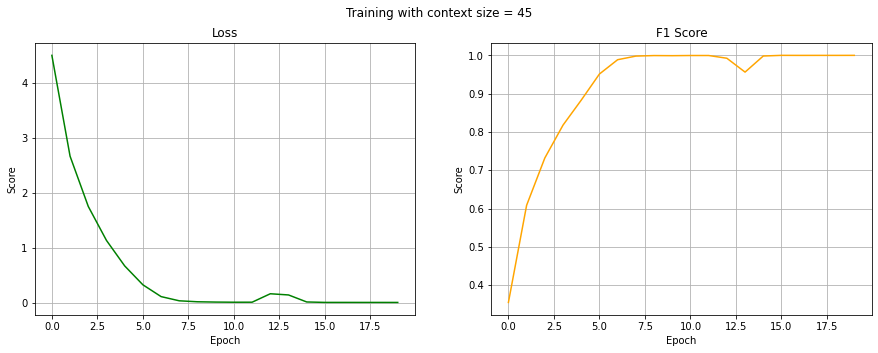

In [12]:
def looping_step(dataloader, model, optimizer, criterion, metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_losses = []
    epoch_metric_scores = []
    patience_counter = 0
    
    now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
    path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
    os.makedirs(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}")
    
    # Hyperparameters
    with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 50}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 50}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
        
        batch_losses, batch_metric_scores = training_step(dataloader, model, optimizer, criterion, metric, path_name=path_name)
        epoch_loss = torch.mean(torch.FloatTensor(batch_losses))

        epoch_loss = torch.mean(torch.FloatTensor(batch_losses))
        epoch_losses.append(epoch_loss.item())

        epoch_metric_score = torch.mean(torch.FloatTensor(batch_metric_scores))
        epoch_metric_scores.append(epoch_metric_score.item())
        
        with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                elif epoch_losses[-1] < epoch_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")                    
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                elif epoch_metric_scores[-1] > epoch_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 50, end="\n\n")
            f.write(f"{'=' * 50}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        metric.reset()
    
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_losses, "green")
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_metric_scores, "orange")
    ax_metric_score.grid()

    plt.savefig(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    criterion_name = "Best " + str(criterion).split('(')[0]
    metric_name = "Best " + str(metric).split('(')[0]
    
    print(f"{criterion_name.ljust(18)}: {best_loss:.4f}")
    print(f"{metric_name.ljust(18)}: {best_metric:.4f}")
    print(f"{'Training duration'.ljust(18)}: {((finish_time - start_time) / 60):.3f} minutes.")
    print(f"{'Training date'.ljust(18)}: {now}")
    
    with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 50}\n")
        f.write(f"{criterion_name.ljust(18)}: {best_loss:.4f}\n")
        f.write(f"{metric_name.ljust(18)}: {best_metric:.4f}\n")
        f.write(f"{'Training duration'.ljust(18)}: {((finish_time - start_time) / 60):.3f} minutes.\n")
        f.write(f"{'Training date'.ljust(18)}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    filename_model_params = f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/model_params.pth"
    filename_oov_embedding_dict = open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/oov_embedding_dict.pkl", "ab")
    
    pd.DataFrame(
        data={
            "epoch": list(range(1, len(epoch_losses) + 1)),
            "loss": epoch_losses
        }
    ).to_csv(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/epoch_losses.csv", index=False)
    
    pd.DataFrame(
        data={
            "epoch": list(range(1, len(epoch_metric_scores) + 1)),
            "f1_score": epoch_metric_scores
        }
    ).to_csv(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/epoch_metric_scores.csv", index=False)
    
    torch.save(best_state_dict, filename_model_params)
    pickle.dump({token : embedding for token, embedding in zip(list(labels_to_idx.keys()), model.embedding)}, filename_oov_embedding_dict)
    
    return epoch_losses, epoch_metric_scores

epoch_losses, epoch_metric_scores = looping_step(dataloader, model, optimizer, criterion, metric)

# END

In [13]:
model.embedding

array([[-0.35275733, -2.1040199 ,  1.7610503 , ..., -0.9410262 ,
        -9.405142  , -5.3998246 ],
       [ 6.1720667 ,  1.3604237 ,  0.52581483, ..., -3.6934588 ,
        -5.6055727 ,  3.2385771 ],
       [-0.7165133 , -0.7889339 ,  4.1446905 , ..., -3.7276871 ,
        -0.8792903 ,  0.71734476],
       ...,
       [ 1.307783  , -0.26407596, -3.7720563 , ...,  2.347596  ,
        -2.108782  ,  2.4457908 ],
       [ 2.8201857 ,  0.35596347,  3.2829628 , ...,  0.93782216,
        -4.3886576 ,  6.6973114 ],
       [ 2.9525733 ,  1.0710117 , -0.23509821, ...,  1.9975362 ,
        -2.5879712 ,  2.5029154 ]], dtype=float32)

In [14]:
model.state_dict()

OrderedDict([('bilstm_left_context_feature.weight_ih_l0',
              tensor([[ 0.0706,  0.2561,  0.2478,  ...,  0.0673,  0.0031, -0.4901],
                      [ 0.1736, -0.1573, -0.0235,  ..., -0.1654, -0.2212,  0.0766],
                      [ 0.1346, -0.2606, -0.0259,  ..., -0.0471,  0.3315, -0.2251],
                      ...,
                      [ 0.1141, -0.3636,  0.2988,  ..., -0.1634, -0.0124, -0.2063],
                      [ 0.2902, -0.0515,  0.2353,  ...,  0.0161,  0.3826, -0.3515],
                      [-0.0950,  0.1758,  0.0781,  ..., -0.1532,  0.0128, -0.0768]])),
             ('bilstm_left_context_feature.weight_hh_l0',
              tensor([[ 0.0006, -0.0300, -0.1543,  ..., -0.0460,  0.1362,  0.1719],
                      [ 0.0598, -0.0329, -0.1208,  ...,  0.1009,  0.0883, -0.1755],
                      [-0.2247,  0.0433,  0.1569,  ...,  0.0601, -0.0521, -0.0093],
                      ...,
                      [-0.0572,  0.0920, -0.2104,  ..., -0.1109, -0.008